In [1]:
# import pickle
# with open("/home/bjangley/VPR/vbr/spagna_train0_00/ouster_points/data/.dtype.pkl", "rb") as f:
#     dtype = pickle.load(f)
# print(dtype)


In [2]:
import os
import numpy as np
from PIL import Image
from vbrDataset import vbrDataset, load_calibration, generate_depth_and_scene_maps  # adjust import as needed

# Set paths
ROOT = "/home/bjangley/VPR/vbr/spagna_train0_00"
CALIB_YAML = "/home/bjangley/VPR/vbr/spagna_train0_00/vbr_calib.yaml"
POSES = "/home/bjangley/VPR/vbr/spagna_train0_gt.txt"
OUTPUT_DIR = os.path.join(ROOT, "depthmaps_npy")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load dataset and calibration
dataset = vbrDataset(ROOT, POSES)
calib = load_calibration(CALIB_YAML)
K = calib['cam_l']['K']
T_cam_lidar = calib['cam_l']['T_cam_lidar']

# # Export first 10 depth maps
# for i in range(10):
#     item = dataset[i]
#     img_path = item['image_left']
#     lidar_pts = item['lidar_points']

#     if lidar_pts.shape[0] < 5:
#         print(f"[{i}] Skipped (no lidar)")
#         continue

#     # Load image to get size
#     img = Image.open(img_path)
#     img_shape = img.size[::-1]  # (H, W)

#     # Generate depth and scene maps
#     depth, scene = generate_depth_and_scene_maps(lidar_pts, K, T_cam_lidar, img_shape)

#     # Save .npy
#     out_path = os.path.join(OUTPUT_DIR, f"{i:010d}.npy")
#     np.save(out_path, depth.astype(np.float32))
#     print(f"[{i}] Saved to {out_path}")


In [3]:
import os
print(os.path.exists('/home/bjangley/VPR/mast3r-v2/mast3r/datasets/base/vbr_pairs_dataset.py'))


True


In [4]:
# import sys
# sys.path.append('/home/bjangley/VPR/mast3r-v2/mast3r')  # Adjust to your mast3r-v2 root path
from mast3r.datasets.base.vbr_pairs_dataset import VBRPairsDataset


dataset = VBRPairsDataset(
    root_dir= ROOT,
    pairs_txt='/home/bjangley/VPR/mast3r-v2/pairs_test.txt',
    calib_yaml= CALIB_YAML,
    poses_txt=POSES,
    depth_dir= OUTPUT_DIR,
    resolution=[(512,384)],  #  width x height 
    aug_crop=False     
    # 
)

sample = dataset[0]
print(sample[0].keys())   # anchor
print(sample[1].keys())   # query




dict_keys(['img', 'depthmap', 'camera_intrinsics', 'camera_pose', 'dataset', 'label', 'instance', 'idx', 'is_metric_scale', 'pts3d', 'valid_mask', 'true_shape', 'sky_mask', 'corres', 'rng'])
dict_keys(['img', 'depthmap', 'camera_intrinsics', 'camera_pose', 'dataset', 'label', 'instance', 'idx', 'is_metric_scale', 'pts3d', 'valid_mask', 'true_shape', 'sky_mask', 'corres', 'rng'])


dict_keys(['img', 'depthmap', 'camera_intrinsics', 'camera_pose', 'dataset', 'label', 'instance', 'idx', 'is_metric_scale', 'pts3d', 'valid_mask', 'true_shape', 'sky_mask', 'corres', 'rng'])
torch.Size([3, 384, 512]) (384, 512)


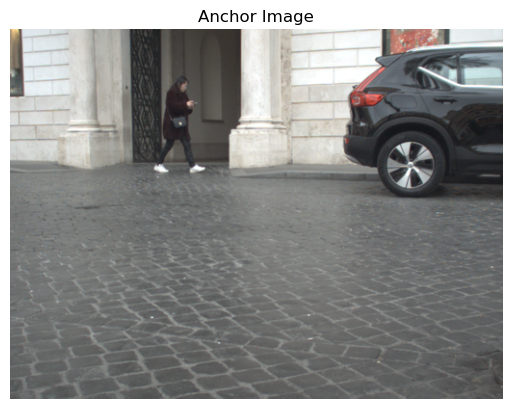

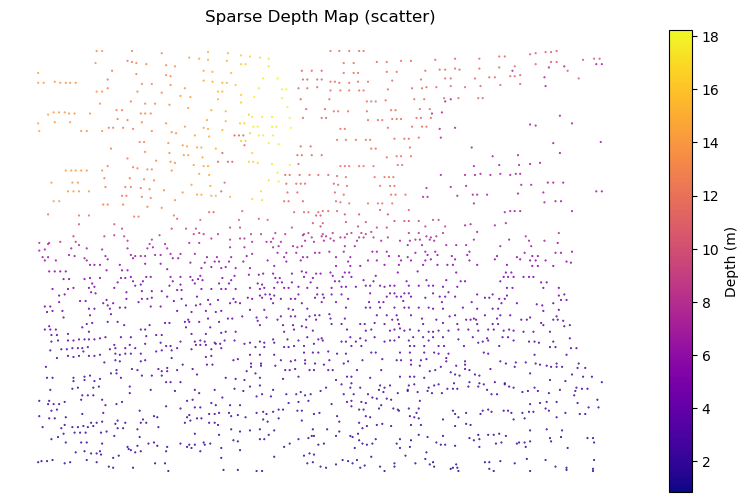

[[ 9.9955165e-01  2.9599456e-02  4.5091053e-03 -2.8860001e-03]
 [-2.9613806e-02  9.9955648e-01  3.1495744e-03 -2.6149999e-03]
 [-4.4138795e-03 -3.2816939e-03  9.9998486e-01 -6.7600003e-04]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [5]:
anchor, query = dataset[4]
print(anchor.keys())
print(anchor['img'].shape, anchor['depthmap'].shape)
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

img = anchor['img'].permute(1, 2, 0).numpy()  # CxHxW → HxWxC
img_vis = (img + 1.0) / 2.0  # Scale to [0, 1]

plt.imshow(img_vis)
plt.title("Anchor Image")
plt.axis("off")
plt.show()



import matplotlib.pyplot as plt
import numpy as np

depth = anchor['depthmap']
valid_mask = depth > 0

# Get coordinates of valid pixels
v_coords, u_coords = np.where(valid_mask)
depth_values = depth[v_coords, u_coords]

# Plot as scatter
plt.figure(figsize=(10, 6))
plt.scatter(u_coords, v_coords, c=depth_values, cmap='plasma', s=1, marker='.')
plt.gca().invert_yaxis()  # Match image coordinate system
plt.colorbar(label='Depth (m)')
plt.title("Sparse Depth Map (scatter)")
plt.axis('off')
plt.show()


print(query['camera_pose'])  # Should be 4x4


In [6]:
from mast3r.model import AsymmetricMASt3R


## this will convert the model to a local version
# model = AsymmetricMASt3R.from_pretrained("naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric")
# model.save_pretrained("/home/bjangley/VPR/mast3r-v2/checkpoints/mast3r_vitlarge_local")


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [7]:
import torch
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs
from dust3r.inference import inference

device = 'cuda:6'
checkpoint_path = "/home/bjangley/VPR/mast3r-v2/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"

# Load model from local checkpoint
model = AsymmetricMASt3R.from_pretrained(checkpoint_path).to(device).eval()


... loading model from /home/bjangley/VPR/mast3r-v2/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/model.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/bjangley/VPR/mast3r-v2/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


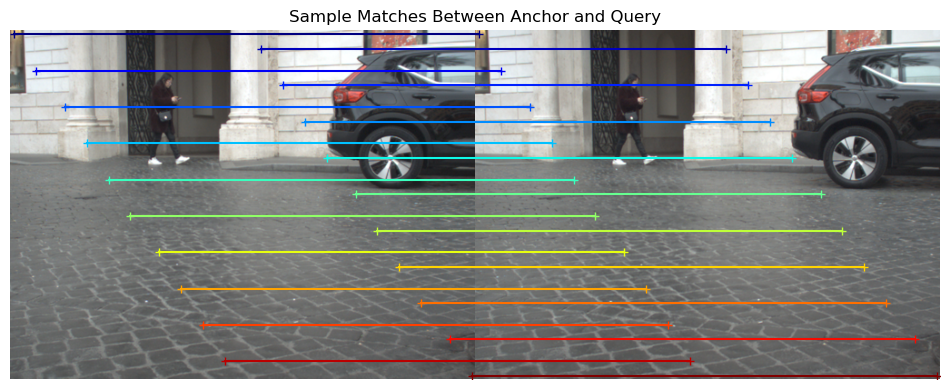

In [8]:
anchor, query = dataset[0]

# --- Prepare views for inference (only 'img' is needed) ---
# Dataset loading
anchor, query = dataset[0]

# Correctly wrap views
view1 = {
    'img': anchor['img'].unsqueeze(0),
    'true_shape': np.int32([anchor['img'].shape[1:]]),
    'idx': 0,
    'instance': '0'
}
view2 = {
    'img': query['img'].unsqueeze(0),
    'true_shape': np.int32([query['img'].shape[1:]]),
    'idx': 1,
    'instance': '1'
}

# Final input format
input_batch = [(view1, view2)]

# Run inference
with torch.no_grad():
    output = inference(input_batch, model, device=device, batch_size=1, verbose=False)



# --- Extract descriptors ---
desc1 = output['pred1']['desc'].squeeze(0).detach()
desc2 = output['pred2']['desc'].squeeze(0).detach()

# --- Find 2D-2D matches ---
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                               device=device, dist='dot', block_size=8192)

# --- Visualize matches ---
n_viz = 20
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0 = matches_im0[match_idx_to_viz]
viz_matches_im1 = matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for view in [view1, view2]:
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant')
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant')
img = np.concatenate((img0, img1), axis=1)

plt.figure(figsize=(12, 6))
plt.imshow(img)
cmap = plt.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    plt.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)))
plt.axis('off')
plt.title("Sample Matches Between Anchor and Query")
plt.show()

In [9]:
from PIL import Image
path = "/home/bjangley/VPR/mast3r-old/datasets/aachenv11/images/db/1.jpg"
img = Image.open(path)
print(img.size)  # Should print (width, height)

(1600, 1063)


In [10]:
import torch
from torch.utils.data import DataLoader
# Wrap in a DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Try fetching a batch
for batch in loader:
    print("Batch loaded successfully!")
    print(batch)
    break  # Just check the first batch

Batch loaded successfully!
[{'img': tensor([[[[ 0.1373,  0.5529,  0.7569,  ...,  0.7804,  0.7725,  0.7725],
          [ 0.1137,  0.5451,  0.7725,  ...,  0.7882,  0.7647,  0.7725],
          [ 0.0902,  0.5059,  0.7647,  ...,  0.7804,  0.7569,  0.7490],
          ...,
          [-0.3098, -0.3098, -0.3098,  ..., -0.3569, -0.3490, -0.3412],
          [-0.3255, -0.3176, -0.3020,  ..., -0.3098, -0.3098, -0.3490],
          [-0.3255, -0.2941, -0.2784,  ..., -0.2863, -0.2941, -0.3098]],

         [[-0.1059,  0.2235,  0.5216,  ...,  0.8510,  0.8353,  0.8275],
          [-0.1059,  0.2314,  0.5137,  ...,  0.8431,  0.8353,  0.8196],
          [-0.1137,  0.1922,  0.4980,  ...,  0.8353,  0.8275,  0.8275],
          ...,
          [-0.2706, -0.3098, -0.3176,  ..., -0.3333, -0.3412, -0.3725],
          [-0.3255, -0.3176, -0.2863,  ..., -0.3098, -0.3098, -0.3333],
          [-0.3333, -0.2784, -0.2314,  ..., -0.2863, -0.2941, -0.2863]],

         [[-0.2157, -0.0667, -0.0118,  ...,  0.8824,  0.8353,  0.8

In [11]:
for batch in loader:
    # batch is a list of dicts (views)
    for i, view in enumerate(batch):
        valid_mask = view['valid_mask']
        # If using DataLoader with default collate_fn, valid_mask might be a tensor or numpy array
        if isinstance(valid_mask, torch.Tensor):
            valid_mask_np = valid_mask.numpy()
        else:
            valid_mask_np = np.array(valid_mask)
        print(f"View {i} valid pixel count:", valid_mask_np.sum())
    break  # Only check the first batch


View 0 valid pixel count: 1850
View 1 valid pixel count: 1850


In [12]:
model.eval()

# Get a stereo pair from the dataset
views = dataset[0]  # views is [view1, view2]
view1, view2 = views

# The model expects dicts, not just tensors
model.eval()
with torch.no_grad():
    output = model(view1, view2)
print("Model forward successful!")



TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray